<a href="https://colab.research.google.com/github/Esim0n0/Used-Car-Prediction_LightGBM/blob/main/RUsed_Car_Prediction_03_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Used Car Prediction**

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from google.colab import files
uploaded = files.upload()
df = pd.read_csv('dc_used_cars.csv', sep=',', on_bad_lines='skip', encoding='latin-1')
# or 'iso-8859-1' or 'cp1252' depending on the file's actual encoding
print(df.columns)
# Replace non-standard missing indicators with NaN in the DataFrame
df.replace(['', 'â€“'], np.nan, inplace=True)

# Fill categorical missing values with the mode
for column in ['fuel_type', 'accident', 'clean_title']:
    if column in df.columns:
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        print(f"Column {column} not found in the DataFrame.")

# Replace non-numeric characters from 'milage' and 'price' columns
# Original line: df['milage'] = pd.to_numeric(df['milage'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce')
df['milage'] = pd.to_numeric(df['milage'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce').fillna(0)  # Fill NaN with 0
df['milage'] = df['milage'].astype(float) # Convert to float
df['price'] = pd.to_numeric(df['price'].astype(str).str.replace(r'[^0-9]', '', regex=True), errors='coerce')
# Perform one-hot encoding on categorical features
df = pd.get_dummies(df, columns=['brand', 'model', 'transmission', 'fuel_type', 'clean_title', 'accident', 'int_col', 'ext_col'], drop_first=True)

import re
# Define a function to extract engine size (in liters)
def extract_engine_liter(engine_desc):
    match = re.search(r'(\d+\.\d+|\d+)\s*(?:L|liter)', engine_desc)
    if match:
        return float(match.group(1))  # Return the numeric value
    return np.nan  # Return NaN if no match is found

# Define a function to extract cylinder count (V6, I4, etc.)
def extract_cylinder_count(engine_desc):
    if 'electric' in engine_desc.lower():
        return 0  # For electric cars, no cylinders
    match = re.search(r'(I\d+|V\d+|Straight \d+)', engine_desc)
    if match:
        # Map engine types to cylinder count
        cylinder_mapping = {
            'I4': 4, '4 Cylinder': 4, 'I6': 6, 'V6': 6, 'V8': 8, 'V10': 10, 'V12': 12, 'Straight 6': 6, '3 Cylinder': 3, '4 Cylinder': 4, '6 Cylinder': 6, '8 Cylinder': 8, '10 Cylinder': 10, '12 Cylinder': 12,
        }
        engine_type = match.group(0)  # Get the matched engine type
        return cylinder_mapping.get(engine_type, np.nan)  # Return the mapped cylinder count
    return np.nan  # Return NaN if no match is found

# Define a function to check if the car is electric
def is_electric(engine_desc):
    if 'electric' in engine_desc.lower():
        return 1  # Electric car
    return 0  # Not electric

# Apply functions to process the engine descriptions
df['engine_liter'] = df['engine'].apply(extract_engine_liter)
df['cylinder_count'] = df['engine'].apply(extract_cylinder_count)
df['is_electric'] = df['engine'].apply(is_electric)

# Impute missing engine_liter values with the mean of the column
df['engine_liter'].fillna(df['engine_liter'].mean(), inplace=True)
# Impute missing cylinder_count values with the mode (most frequent value) of the column
# Check if mode is empty before accessing element at index 0
mode_values = df['cylinder_count'].mode()
if not mode_values.empty:
    df['cylinder_count'].fillna(mode_values[0], inplace=True)
else:
    # Handle the case where mode is empty (e.g., fill with a default value)
    df['cylinder_count'].fillna(4, inplace=True)  # Filling with 4 as an example
df.drop(columns=['engine'], inplace=True)

Saving dc_used_cars.csv to dc_used_cars.csv
Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'diagnosis', 'Unnamed: 13'],
      dtype='object')


In [49]:
pip install lightgbm

In [50]:
# Define features (X) and target (y)
X = df[['model_year', 'milage', 'price', 'engine_liter', 'cylinder_count', 'is_electric']]
y = df['diagnosis']

# LightGBM

In [51]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()

In [52]:
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [53]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [54]:
df.head()

,model_year,milage,price,diagnosis,Unnamed: 13,brand_Alfa,brand_Aston,brand_Audi,brand_BMW,brand_Bentley,...,ext_col_Yellow,ext_col_Yulong,ext_col_Yulong White,ext_col_designo Diamond White,ext_col_designo Diamond White Bright,ext_col_designo Diamond White Metallic,ext_col_,engine_liter,cylinder_count,is_electric
0,2013,51000.0,10300,0,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,3.7,6.0,0
1,2021,34742.0,38005,1,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,3.8,6.0,0
2,2022,22372.0,54598,1,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,3.5,6.0,0
3,2015,88900.0,15500,0,NaN,False,False,False,False,False,...,False,False,False,False,False,False,False,3.5,0.0,1
4,2021,9835.0,34999,1,NaN,False,False,True,False,False,...,False,False,False,False,False,False,False,2.0,4.0,0


In [55]:
X = X.drop(columns=['Unnamed: 13'], errors='ignore')  # Ignore if it doesn't exist

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Columns: 2502 entries, model_year to is_electric
dtypes: bool(2494), float64(4), int64(4)
memory usage: 9.8 MB


In [57]:
df['diagnosis'].value_counts()

,count
diagnosis,
1,2012
0,1997


In [58]:
X = df[['model_year','milage','price','diagnosis','Unnamed: 13','brand_Alfa','brand_Aston','brand_Audi','brand_BMW','brand_Bentley','ext_col_Yellow','ext_col_Yulong','ext_col_Yulong White','ext_col_designo Diamond White','ext_col_designo Diamond White Bright','ext_col_designo Diamond White Metallic','ext_col_','engine_liter','cylinder_count','is_electric']]
y = df['diagnosis']

In [59]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [60]:
import lightgbm as lgb
import re
import pandas as pd  # Import pandas

# Resetting index before splitting is crucial
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Replace special characters in column names with underscores
# This is done on the original X DataFrame before the split
X.columns = [re.sub('[^A-Za-z0-9_]+', '_', col) for col in X.columns]

# Split data into training and testing sets
# This should be done *after* cleaning the column names
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1425, number of negative: 1381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 2806, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507840 -> initscore=0.031364
[LightGBM] [Info] Start training from score 0.031364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier()

In [61]:
clf = LGBMClassifier(
    n_estimators=100,      # Reduce number of trees
    max_depth=5,           # Limit tree depth
    lambda_l1=0.1,         # L1 regularization
    lambda_l2=0.1,         # L2 regularization
    min_child_samples=20   # Minimum data in leaf nodes
)

In [62]:
clf.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 1425, number of negative: 1381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 2806, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507840 -> initscore=0.031364
[LightGBM] [Info] Start training from score 0.031364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMClassifier(lambda_l1=0.1, lambda_l2=0.1, max_depth=5)

In [63]:
# predict the results
y_pred=clf.predict(X_test)

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


In [64]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 1.0000


In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Number of positive: 1610, number of negative: 1597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 3207, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502027 -> initscore=0.008107
[LightGBM] [Info] Start training from score 0.008107
[LightGBM] [Warning] No further sp

In [66]:
y_pred_train = clf.predict(X_train)

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1


In [67]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 1.0000


In [68]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
Training set score: 1.0000
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
Test set score: 1.0000


In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'lambda_l1': [0.0, 0.1, 1.0],
    'lambda_l2': [0.0, 0.1, 1.0]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)


[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Info] Number of positive: 1425, number of negative: 1381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 612
[LightGBM] [Info] Number of data points in the train set: 2806, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507840 -> initscore=0.031364
[LightGBM] [Info] Start training from score 0.031364
[LightGBM] [Warning] No further sp

In [70]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[616   0]
 [  0 587]]

True Positives(TP) =  616

True Negatives(TN) =  587

False Positives(FP) =  0

False Negatives(FN) =  0


<Axes: >

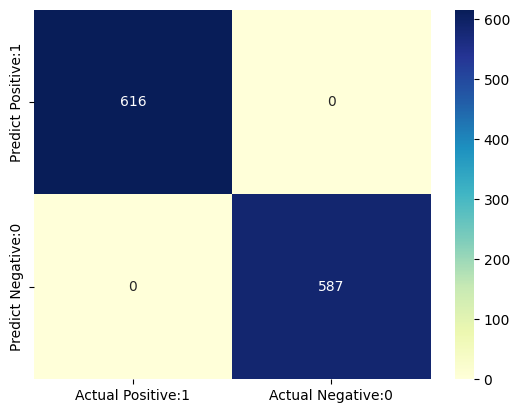

In [71]:
# Import the seaborn library and give it the alias 'sns'
import seaborn as sns

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [72]:
print("Target class distribution:")
print(y.value_counts(normalize=True))  # Normalize for proportions

Target class distribution:
diagnosis
1    0.501871
0    0.498129
Name: proportion, dtype: float64


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       616
           1       1.00      1.00      1.00       587

    accuracy                           1.00      1203
   macro avg       1.00      1.00      1.00      1203
weighted avg       1.00      1.00      1.00      1203



In [74]:
print(X.corrwith(y))

model_year                                0.023753
milage                                   -0.027665
price                                    -0.003815
diagnosis                                 1.000000
Unnamed_13                                     NaN
brand_Alfa                               -0.018418
brand_Aston                               0.026175
brand_Audi                                0.024349
brand_BMW                                -0.019191
brand_Bentley                             0.024506
ext_col_Yellow                            0.008511
ext_col_Yulong                            0.015737
ext_col_Yulong_White                      0.015737
ext_col_designo_Diamond_White             0.015737
ext_col_designo_Diamond_White_Bright     -0.015855
ext_col_designo_Diamond_White_Metallic    0.022258
ext_col__                                 0.012027
engine_liter                             -0.005516
cylinder_count                           -0.024659
is_electric                    